# Stratification - beating the $1 / \sqrt{N}$ law

The key idea in stratification is to split the data (or domain for integrals) on which we wish to calculate an expectation into strata (i.e. parts). Then, on each of these strata, we calculate the expectation separately, using whatever method is appropriate for the stratum, and which gives us the lowest variance. These expectations are then combined together to get the final value, which has better precision than the usual $1 / \sqrt{N}$ law.

In other words we can achieve better sampling in needed regions by going away from a one-size-fits-all sampling scheme. One way to think about it is that regions with higher variability might need more samples, while not-so-varying regions could make do with less.

Stratification is thus a method for obtaining better estimates by subdividing a sample into more homogeneous strata, and then combining the result from each of these to get the final result. The method especially has its real life application in situations, where sampling is expensive, e.g. poling for elections, sampling customers, and patient data analysis.

For more information see P. R. Bevington: page 75-78

***

### Authors: 
- Troels C. Petersen (Niels Bohr Institute)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats

Define the parameters of the program:

In [2]:
save_plots = False         # Determining if plots are saved or not
r = np.random
r.seed(42)

# Define short hand function:
Y = lambda x: x/(x**2+1.0);

# Set parameters:
N = 10000         # Number of points
Ns = 10           # Number of strata 
Ntry = 1000       # Number of points we use for finding the Std. in each strata
Nrep = 1000       # Number of times we repeat the stratification experiment

xmin =  0
xmax = 10
step = (xmax - xmin) / Ns

Imc = np.zeros(Nrep)    # Results from "normal" MC sampling (i.e. unstratified)
Is  = np.zeros(Nrep)    # Results from stratified sampling with equal sampling in each strata (better)
Is2 = np.zeros(Nrep)    # Results from stratified sampling with sampling according to Std. in strata (best)

In [3]:
# If we wanted to estimate the integral, then we would use the below (not used in this exercise):
intY = lambda x: np.log(x**2 + 1.0)/2.0;

# Analytic solution :
Ic = intY(xmax)-intY(xmin)

## Plot the distribution and its stratification:

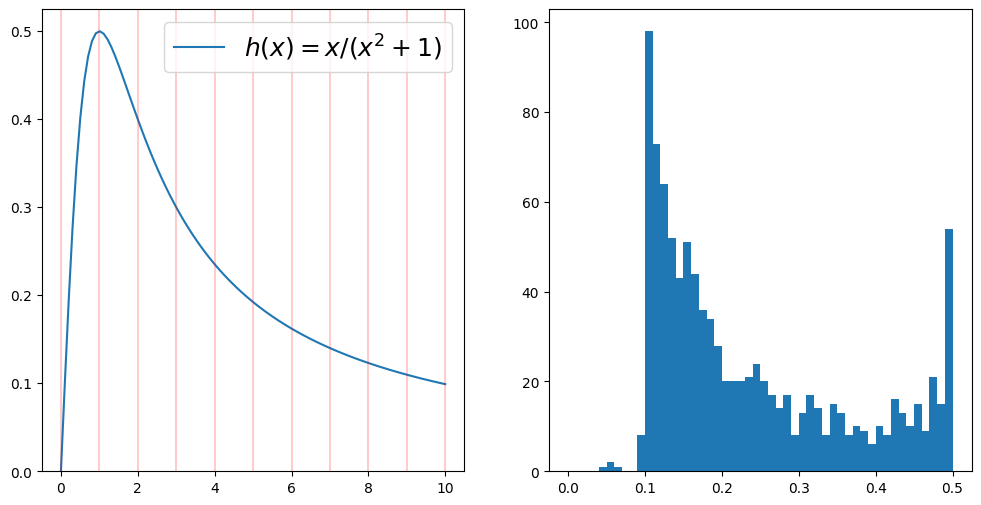

In [4]:
plt.figure(figsize=[12,6])

## Ploting the original functions h(x)
plt.subplot(1,2,1)
x = np.linspace(0,10,100)
plt.plot(x, Y(x), label=u'$h(x) = x/(x^2+1)$')
plt.legend(loc="upper right", fontsize=18)
plt.ylim(0.0,None)
for j in range(Ns+1):
    plt.axvline(xmin + j*step, 0, 1, color='r', alpha=0.2)

# Plotting the values obtained from inserting uniformily into h(x)
plt.subplot(1,2,2)
Utry = r.uniform(low=xmin, high=xmax, size=Ntry)      # Ntry random uniform numbers
Ytry = Y(Utry)                                                # h(x) value of the above numbers
plt.hist(Ytry, bins=50, range=(0.0, 0.5));

## Idea of stratification:

We want to find the mean of $h(x)$ given some (fixed) number of samplings of $x$. We can of course just take a lot of values of $x$ and calculate values of $h(x)$ and then take the mean of these. This is the usual Monte Carlo method that we use.

But when $x$ is high, the standard deviation (Std) is not very large in $h(x)$, and so we can get a better estimate from:<br>
1. Calculating the mean in each strata (using an equal number of samplings in each) and then combining these means.
2. Use a different number of samplings in each strata, proportinal to the Std (since small Std requires small number of samplings).

Thus, instead of taking the mean of $N$ samples, we break the interval into $M$ strata and take $n_j$ samples for each strata $j$, such that $N=\sum_j n_j$.

If we defining the mean for each strata as $\hat{\mu}_j = \frac{1}{n_j} \sum_{x_{ij} \in f_j} h(x_{ij})$, then we can then define the stratified estimator of the overall expectation based on the above means: $\hat{\mu}_s = \sum_j p_j \hat{\mu}_j$, which is an unbiased estimator of $\mu$.

In [5]:
sigmas = np.zeros(Ns)
Umin = 0 
Umax = step
for strata in np.arange(0, Ns) :
    strata_mask = (Utry >= Umin) & (Utry < Umax)     # Select only the values that are in the current strata
    sigmas[strata] = np.std(Ytry[strata_mask])
    Umin = Umin + step
    Umax = Umin + step

# From the above, calculate the suggested number of samplings to make in each strata:
nums = np.floor(N*sigmas/np.sum(sigmas) + 0.5).astype(int)

# Print results:
np.set_printoptions(precision=3)
print("Sigmas: ", sigmas)        # Std. (i.e. proportionel to uncertainty in mean) in each strata
print("Numbers:", nums)         # Suggested number of samplings in each strata
print("Sum:    ", np.sum(nums))     # Sum of suggestions (should roughly match input size)

Sigmas:  [0.139 0.03  0.027 0.017 0.012 0.009 0.006 0.005 0.004 0.003]
Numbers: [5481 1191 1069  687  489  355  246  197  166  119]
Sum:     10000


## Plot "experimental" process:

Distribution of points from one experiment:

In [6]:
for k in np.arange(0, Nrep):

    # First, lets do it with mean MC (standard) method: 
    U = np.random.uniform(low=xmin, high=xmax, size=N)
    Imc[k] = (xmax-xmin) * np.mean(Y(U))

    # Next, stratified it in Ns regions with equal (I) and optimal (I2) number in each strata:
    Umin = 0 
    Umax = step
    Ii = 0
    I2i = 0
    for reg in np.arange(0, Ns) :
        x = np.random.uniform(low=Umin, high=Umax, size=N//Ns);
        Ii = Ii + (Umax-Umin)*np.mean(Y(x))
        x2 = np.random.uniform(low=Umin, high=Umax, size=nums[reg]);
        I2i = I2i + (Umax-Umin)*np.mean(Y(x2))
        Umin = Umin + step
        Umax = Umin + step


    Is[k] = Ii
    Is2[k] = I2i

# Resulting Std of the estimates:
print(f"  Standard MC: {np.std(Imc):6.4f}     Stratified:  Equal N: {np.std(Is):6.4f}   Sigma N: {np.std(Is2):6.4f}")

  Standard MC: 0.0125     Stratified:  Equal N: 0.0049   Sigma N: 0.0026


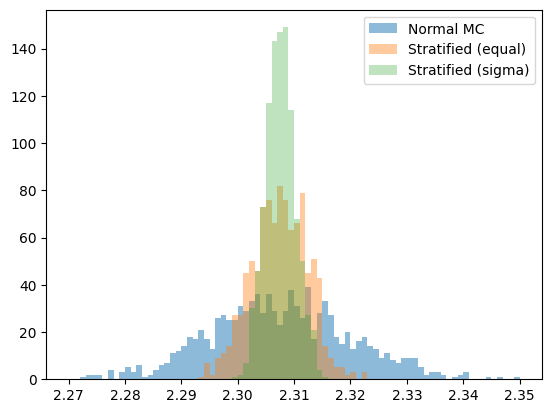

In [7]:
# Plotting the distribution of results from repeated "experiments":
Nbins = 80
plt.hist(Imc, bins=Nbins, range=(2.27,2.35), histtype='stepfilled', label=u'Normal MC', alpha=0.5)
plt.hist(Is,  bins=Nbins, range=(2.27,2.35), histtype='stepfilled', label=u'Stratified (equal)', alpha=0.4)
plt.hist(Is2, bins=Nbins, range=(2.27,2.35), histtype='stepfilled', label=u'Stratified (sigma)', alpha=0.3)
plt.legend();

In [8]:
#Q1 how large is gain precision

gain_equal = np.std(Imc) / np.std(Is)
gain_sigma = np.std(Is) / np.std(Is2)
gain_overall = np.std(Imc) / np.std(Is2)
print(f"Gain in precision (std. reduction): Equal N: {gain_equal:6.2f}   Sigma N: {gain_sigma:6.2f}   Overall: {gain_overall:6.2f}")

Gain in precision (std. reduction): Equal N:   2.54   Sigma N:   1.88   Overall:   4.79


In [9]:
def gaussian_x_3(x, mu, sigma,mu2, sigma2,mu3, sigma3):
    g1 = 1.0/(sigma * np.sqrt(2.0 * np.pi)) * np.exp( -0.5 * ((x - mu)/sigma)**2 )
    g2 = 1.0/(sigma2 * np.sqrt(2.0 * np.pi)) * np.exp( -0.5 * ((x - mu2)/sigma2)**2 )
    g3 = 1.0/(sigma3 * np.sqrt(2.0 * np.pi)) * np.exp( -0.5 * ((x - mu3)/sigma3)**2 )
    return g1 + g2 + g3

Imc_2 = np.zeros(Nrep)    # Results from "normal" MC sampling (i.e. unstratified)
Is_2 = np.zeros(Nrep)    # Results from stratified sampling with equal sampling in each strata (better)
Is2_2 = np.zeros(Nrep)    # Results from stratified sampling with sampling according to Std. in strata (best)


mu = 0
sigma = 1.0
mu2 = 0.5
sigma2 = 1.5
mu3 = 1.0
sigma3 = 4.0

xmin =  -10
xmax = 10
step = (xmax - xmin) / Ns


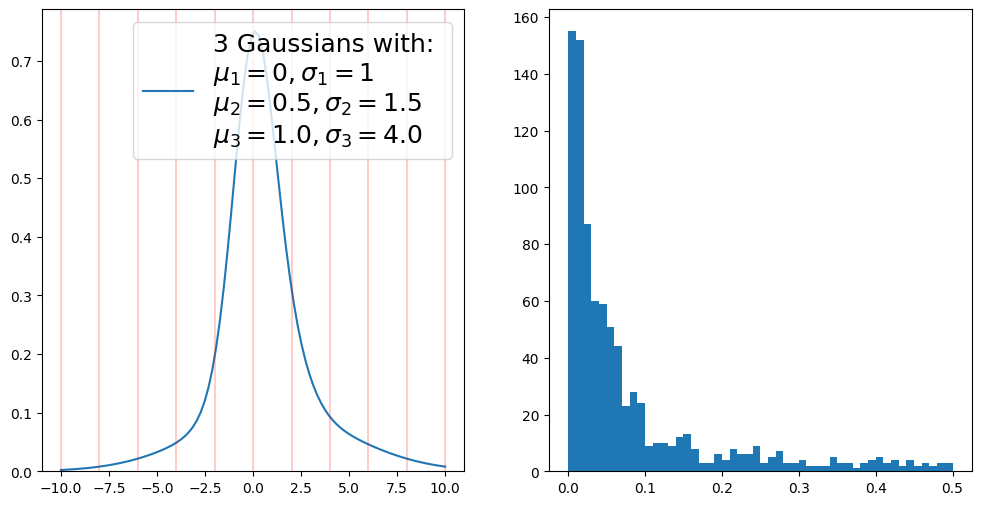

In [10]:
plt.figure(figsize=[12,6])

## Ploting the original functions h(x)
plt.subplot(1,2,1)
x = np.linspace(-10,10,100)
plt.plot(x, gaussian_x_3(x, mu, sigma, mu2, sigma2, mu3, sigma3), label=r'3 Gaussians with: ' + '\n' + r'$\mu_1=0,\sigma_1=1$' + '\n' + r'$\mu_2=0.5,\sigma_2=1.5$' + '\n' + r'$\mu_3=1.0,\sigma_3=4.0$')
plt.legend(loc="upper right", fontsize=18)
plt.ylim(0.0,None)
for j in range(Ns+1):
    plt.axvline(xmin + j*step, 0, 1, color='r', alpha=0.2)

# Plotting the values obtained from inserting uniformily into h(x)
plt.subplot(1,2,2)
Utry_2 = r.uniform(low=xmin, high=xmax, size=Ntry)      # Ntry random uniform numbers
Ytry_2 = gaussian_x_3(Utry_2, mu, sigma, mu2, sigma2, mu3, sigma3)                                                # h(x) value of the above numbers
plt.hist(Ytry_2, bins=50, range=(0, 0.5));

In [11]:
# # # Calculate sigmas for the 3-Gaussian distribution
# # sigmas_2 = np.zeros(Ns)
# # Umin = xmin 
# # Umax = step
# # for strata in np.arange(0, Ns):
# #     strata_mask = (Utry_2 >= Umin) & (Utry_2 < Umax)     # Select only values in current strata
# #     sigmas_2[strata] = np.std(Ytry_2[strata_mask])
# #     Umin = Umin + step
# #     Umax = Umin + step

# # # Calculate suggested number of samplings for each strata (based on sigmas_2)
# # nums_2 = np.floor(N*sigmas_2/np.sum(sigmas_2) + 0.5).astype(int)

# # # Print results:
# # np.set_printoptions(precision=3)
# # print("Sigmas (Gaussian): ", sigmas_2)        # Std. in each strata for Gaussian
# # print("Numbers (Gaussian):", nums_2)         # Suggested number of samplings
# # print("Sum (Gaussian):    ", np.sum(nums_2)) # Should roughly match N

# # NEW CODE (use KNOWN Gaussian standard deviations):
# sigmas_2 = np.array([sigma, sigma2, sigma3])  # Known stds: [1.0, 1.5, 4.0]

# # Calculate suggested number of samplings for each Gaussian (based on sigma)
# nums_2 = np.floor(N*sigmas_2/np.sum(sigmas_2) + 0.5).astype(int)

# # Print results:
# np.set_printoptions(precision=3)
# print("\n=== Q2: Using KNOWN Gaussian Standard Deviations ===")
# print("Sigmas (Gaussian): ", sigmas_2)        # [1.0, 1.5, 4.0]
# print("Numbers (Gaussian):", nums_2)         # Allocation: [1000, 1500, 7500]
# print("Sum (Gaussian):    ", np.sum(nums_2)) # Should be 10000



In [12]:

# def stratified_sampling_by_gaussian_component(N, Nrep, mu, sigma, mu2, sigma2, mu3, sigma3, nums_optimal):
#     """
#     Stratification by GAUSSIAN COMPONENT (not x-regions).
#     Strata are the 3 Gaussian distributions themselves.
#     """
    
#     Imc = np.zeros(Nrep)
#     Is = np.zeros(Nrep)
#     Is2 = np.zeros(Nrep)
    
#     # Equal allocation: N/3 from each Gaussian
#     nums_equal = np.array([N//3, N//3, N//3])
    
#     for k in np.arange(0, Nrep):
        
#         # ===== Standard MC: Sample equally from all 3 Gaussians =====
#         samples_mc = np.concatenate([
#             np.random.normal(mu, sigma, N//3),
#             np.random.normal(mu2, sigma2, N//3),
#             np.random.normal(mu3, sigma3, N//3)
#         ])
#         y_mc = gaussian_x_3(samples_mc, mu, sigma, mu2, sigma2, mu3, sigma3)
#         Imc[k] = np.mean(y_mc)
        
#         # ===== Stratified Equal: N/3 samples from each component =====
#         samples_equal = np.concatenate([
#             np.random.normal(mu, sigma, nums_equal[0]),
#             np.random.normal(mu2, sigma2, nums_equal[1]),
#             np.random.normal(mu3, sigma3, nums_equal[2])
#         ])
#         y_equal = gaussian_x_3(samples_equal, mu, sigma, mu2, sigma2, mu3, sigma3)
#         Is[k] = np.mean(y_equal)
        
#         # ===== Stratified Optimal: Allocate by sigma =====
#         samples_optimal = np.concatenate([
#             np.random.normal(mu, sigma, nums_optimal[0]),
#             np.random.normal(mu2, sigma2, nums_optimal[1]),
#             np.random.normal(mu3, sigma3, nums_optimal[2])
#         ])
#         y_optimal = gaussian_x_3(samples_optimal, mu, sigma, mu2, sigma2, mu3, sigma3)
#         Is2[k] = np.mean(y_optimal)
    
#     return Imc, Is, Is2


# # ===== REPLACE THE OLD FUNCTION CALL =====
# # OLD: Imc_2, Is_2, Is2_2 = stratified_sampling_experiment(gaussian_func, xmin, xmax, Ns, N, Nrep, nums_2, step)

# # NEW: Use the Gaussian-based stratification
# Imc_2, Is_2, Is2_2 = stratified_sampling_by_gaussian_component(N, Nrep, mu, sigma, mu2, sigma2, mu3, sigma3, nums_2)

# # Print results:
# print(f"\n=== Q2: Stratification by Gaussian Component ===")
# print(f"  Standard MC:              σ = {np.std(Imc_2):6.4f}")
# print(f"  Stratified Equal (N/3):   σ = {np.std(Is_2):6.4f}")
# print(f"  Stratified Optimal (σ):   σ = {np.std(Is2_2):6.4f}")

# # Calculate gains:
# gain_equal = np.std(Imc_2) / np.std(Is_2)
# gain_sigma = np.std(Is_2) / np.std(Is2_2)
# gain_overall = np.std(Imc_2) / np.std(Is2_2)
# print(f"\nGain in precision: Equal N: {gain_equal:6.2f}   Sigma N: {gain_sigma:6.2f}   Overall: {gain_overall:6.2f}")

# # Plotting the distribution of results from repeated "experiments":
# Nbins = 80
# plt.figure(figsize=[10, 6])
# plt.hist(Imc_2, bins=Nbins, histtype='stepfilled', label=u'Normal MC', alpha=0.5)
# plt.hist(Is_2,  bins=Nbins, histtype='stepfilled', label=u'Stratified (equal)', alpha=0.4)
# plt.hist(Is2_2, bins=Nbins, histtype='stepfilled', label=u'Stratified (sigma)', alpha=0.3)
# plt.xlabel('Estimated Mean')
# plt.ylabel('Frequency')
# plt.title('Q2: Stratification by Gaussian Component')
# plt.legend()
# plt.show()

Optimal allocation: [1538 2308 6154] (sum=10000)
Equal allocation: [3333 3333 3333] (sum=9999)

=== Q2: Stratification by Gaussian Component ===
  Standard MC:              σ = 0.0021
  Stratified Equal (N/3):   σ = 0.0021
  Stratified Optimal (σ):   σ = 0.0022

Gain in precision: Equal N:   1.00   Sigma N:   0.94   Overall:   0.94


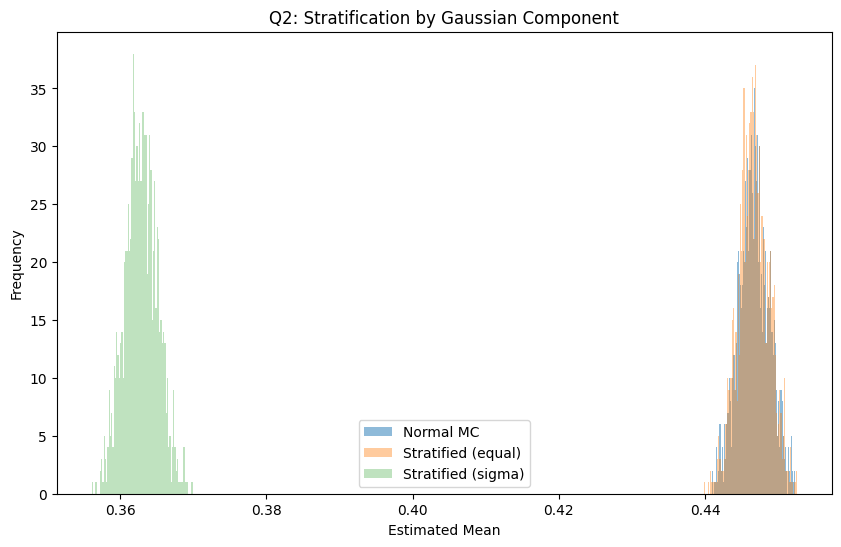

In [13]:
def stratified_sampling_by_gaussian_component(N, Nrep, mu, sigma, mu2, sigma2, mu3, sigma3):
    """
    Stratification by GAUSSIAN COMPONENT (not x-regions).
    Strata are the 3 Gaussian distributions themselves.
    """
    
    Imc = np.zeros(Nrep)
    Is = np.zeros(Nrep)
    Is2 = np.zeros(Nrep)
    
    # Known standard deviations of each Gaussian
    sigmas = np.array([sigma, sigma2, sigma3])
    
    # Optimal allocation: proportional to sigma
    nums_optimal = np.floor(N * sigmas / np.sum(sigmas) + 0.5).astype(int)
    
    # Equal allocation: N/3 from each Gaussian
    nums_equal = np.array([N//3, N//3, N//3])
    
    print(f"Optimal allocation: {nums_optimal} (sum={np.sum(nums_optimal)})")
    print(f"Equal allocation: {nums_equal} (sum={np.sum(nums_equal)})")
    
    for k in np.arange(0, Nrep):
        
        # ===== Standard MC: Sample equally from all 3 Gaussians =====
        samples_mc = np.concatenate([
            np.random.normal(mu, sigma, N//3),
            np.random.normal(mu2, sigma2, N//3),
            np.random.normal(mu3, sigma3, N//3)
        ])
        y_mc = gaussian_x_3(samples_mc, mu, sigma, mu2, sigma2, mu3, sigma3)
        Imc[k] = np.mean(y_mc)
        
        # ===== Stratified Equal: N/3 samples from each component =====
        samples_equal = np.concatenate([
            np.random.normal(mu, sigma, nums_equal[0]),
            np.random.normal(mu2, sigma2, nums_equal[1]),
            np.random.normal(mu3, sigma3, nums_equal[2])
        ])
        y_equal = gaussian_x_3(samples_equal, mu, sigma, mu2, sigma2, mu3, sigma3)
        Is[k] = np.mean(y_equal)
        
        # ===== Stratified Optimal: Allocate by sigma =====
        samples_optimal = np.concatenate([
            np.random.normal(mu, sigma, nums_optimal[0]),
            np.random.normal(mu2, sigma2, nums_optimal[1]),
            np.random.normal(mu3, sigma3, nums_optimal[2])
        ])
        y_optimal = gaussian_x_3(samples_optimal, mu, sigma, mu2, sigma2, mu3, sigma3)
        Is2[k] = np.mean(y_optimal)
    
    return Imc, Is, Is2


# ===== CALL WITH NO EXTRA ARGUMENTS =====
Imc_2, Is_2, Is2_2 = stratified_sampling_by_gaussian_component(N, Nrep, mu, sigma, mu2, sigma2, mu3, sigma3)

# Print results:
print(f"\n=== Q2: Stratification by Gaussian Component ===")
print(f"  Standard MC:              σ = {np.std(Imc_2):6.4f}")
print(f"  Stratified Equal (N/3):   σ = {np.std(Is_2):6.4f}")
print(f"  Stratified Optimal (σ):   σ = {np.std(Is2_2):6.4f}")

# Calculate gains:
gain_equal = np.std(Imc_2) / np.std(Is_2)
gain_sigma = np.std(Is_2) / np.std(Is2_2)
gain_overall = np.std(Imc_2) / np.std(Is2_2)
print(f"\nGain in precision: Equal N: {gain_equal:6.2f}   Sigma N: {gain_sigma:6.2f}   Overall: {gain_overall:6.2f}")

# Plotting the distribution of results from repeated "experiments":
Nbins = 80
plt.figure(figsize=[10, 6])
plt.hist(Imc_2, bins=Nbins, histtype='stepfilled', label=u'Normal MC', alpha=0.5)
plt.hist(Is_2,  bins=Nbins, histtype='stepfilled', label=u'Stratified (equal)', alpha=0.4)
plt.hist(Is2_2, bins=Nbins, histtype='stepfilled', label=u'Stratified (sigma)', alpha=0.3)
plt.xlabel('Estimated Mean')
plt.ylabel('Frequency')
plt.title('Q2: Stratification by Gaussian Component')
plt.legend()
plt.show()

In [14]:
# def stratified_sampling_experiment(func, xmin, xmax, Ns, N, Nrep, nums, step):
    
#     Imc = np.zeros(Nrep)
#     Is = np.zeros(Nrep)
#     Is2 = np.zeros(Nrep)
    
#     for k in np.arange(0, Nrep):
#         # Standard MC sampling
#         U = np.random.uniform(low=xmin, high=xmax, size=N)
#         Imc[k] = (xmax - xmin) * np.mean(func(U))
        
#         # Stratified sampling (equal and sigma-weighted)
#         Umin = xmin
#         Umax = xmin + step
#         Ii = 0
#         I2i = 0
        
#         for reg in np.arange(0, Ns):
#             # Equal sampling per stratum
#             x = np.random.uniform(low=Umin, high=Umax, size=N // Ns)
#             Ii = Ii + (Umax - Umin) * np.mean(func(x))
            
#             # Sigma-weighted sampling
#             x2 = np.random.uniform(low=Umin, high=Umax, size=nums[reg])
#             I2i = I2i + (Umax - Umin) * np.mean(func(x2))
            
#             Umin = Umax
#             Umax = Umax + step
        
#         Is[k] = Ii
#         Is2[k] = I2i
    
#     return Imc, Is, Is2


# gaussian_func = lambda x: gaussian_x_3(x, mu, sigma, mu2, sigma2, mu3, sigma3)


# Imc_2, Is_2, Is2_2 = stratified_sampling_experiment(gaussian_func, xmin, xmax, Ns, N, Nrep, nums_2, step)



# # Print results:
# print(f"  Standard MC: {np.std(Imc_2):6.4f}     Stratified:  Equal N: {np.std(Is_2):6.4f}   Sigma N: {np.std(Is2_2):6.4f}")

# # Calculate gains:
# gain_equal = np.std(Imc_2) / np.std(Is_2)
# gain_sigma = np.std(Is_2) / np.std(Is2_2)
# gain_overall = np.std(Imc_2) / np.std(Is2_2)
# print(f"Gain in precision (std. reduction): Equal N: {gain_equal:6.2f}   Sigma N: {gain_sigma:6.2f}   Overall: {gain_overall:6.2f}")

In [15]:
# # Plotting the distribution of results from repeated "experiments":
# Nbins = 80
# plt.hist(Imc_2, bins=Nbins, range=(2.8,3.2), histtype='stepfilled', label=u'Normal MC', alpha=0.5)
# plt.hist(Is_2,  bins=Nbins, range=(2.8,3.2), histtype='stepfilled', label=u'Stratified (equal)', alpha=0.4)
# plt.hist(Is2_2, bins=Nbins, range=(2.8,3.2), histtype='stepfilled', label=u'Stratified (sigma)', alpha=0.3)
# plt.legend();

***

# Questions:

0. First acquaint yourself with the program, and make sure that you understand what e.g. the parameters `N`, `Ntry`, and `Nrep` refer to!
Then, run the program, and take a look at the results. Make sure you understand both the plots and the numbers printed.

1. How large is the gain in precision when going from MC to equal sampling strata? And when going on to sigma sampling strata?

2. Imagine that you were sampling 100 times from three Gaussian distributions:
       $G_1(\mu=0, \sigma=1.0)$, $G_2(\mu=0.5, \sigma=1.5)$, and $G_1(\mu=1.0, \sigma=4.0)$<br>
   How would you best sample from this combined (3G) PDF? Repeat the above exercises (using known Stds) and see the effect.

# Learning points:

This is an exercise in stratification, i.e. subdividing a sample into more homogenius subsamples to achieve better sample estimates (e.g. mean).

From the exercise you should:
1. Know the difference between normal (MC) sampling and stratified sampling, both equal size sampling per strata and proportional to the strata Std.
2. Understand why stratified sampling is more efficient, and that the gain depends on the size of the differences between strata.
3. Be able to perform stratified sampling, and to design a stratified sampling strategy for a planned (real life) sampling.